In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import functional as tf
from torch import Tensor
from torch.nn import Parameter
import torch.utils.data as Data
from torch.utils.data import RandomSampler
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error
import pennylane as qml
import pytorch_lightning as pl
import math
import time



In [2]:
dfi = pd.read_csv('./Data/Stock/^FTSE.csv',parse_dates=True,index_col='Datetime')
dfi

,Close,High,Low,Open
Datetime,,,,
2022-10-31 08:00:00+00:00,7041.379883,7055.500000,7030.120117,7047.669922
2022-10-31 09:00:00+00:00,7060.120117,7061.109863,7037.140137,7041.439941
2022-10-31 10:00:00+00:00,7058.430176,7065.600098,7051.580078,7060.220215
2022-10-31 11:00:00+00:00,7058.910156,7066.100098,7054.279785,7058.500000
2022-10-31 12:00:00+00:00,7064.100098,7064.569824,7055.509766,7058.890137
...,...,...,...,...
2024-10-28 12:00:00+00:00,8231.879883,8232.809570,8208.919922,8219.179688
2024-10-28 13:00:00+00:00,8257.580078,8262.190430,8231.799805,8231.820312
2024-10-28 14:00:00+00:00,8280.080078,8280.660156,8252.480469,8257.599609


In [3]:
# dfi['date'] = pd.to_datetime(dfi['Time'])
# df = dfi.loc[dfi['date'] > '2024-07-19']
# df

In [4]:
df = dfi[['Open','High','Low','Close']]
df = df.dropna()
#df = df.reset_index(drop=True)
df

,Open,High,Low,Close
Datetime,,,,
2022-10-31 08:00:00+00:00,7047.669922,7055.500000,7030.120117,7041.379883
2022-10-31 09:00:00+00:00,7041.439941,7061.109863,7037.140137,7060.120117
2022-10-31 10:00:00+00:00,7060.220215,7065.600098,7051.580078,7058.430176
2022-10-31 11:00:00+00:00,7058.500000,7066.100098,7054.279785,7058.910156
2022-10-31 12:00:00+00:00,7058.890137,7064.569824,7055.509766,7064.100098
...,...,...,...,...
2024-10-28 12:00:00+00:00,8219.179688,8232.809570,8208.919922,8231.879883
2024-10-28 13:00:00+00:00,8231.820312,8262.190430,8231.799805,8257.580078
2024-10-28 14:00:00+00:00,8257.599609,8280.660156,8252.480469,8280.080078


In [5]:
df['nxt_target'] = df['Close'].shift(-1)
df['nxt_target'][len(df)-1] = df['nxt_target'][len(df)-2]

/tmp/ipykernel_1300/2437957435.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df['nxt_target'][len(df)-1] = df['nxt_target'][len(df)-2]
/tmp/ipykernel_1300/2437957435.py:2: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  df['nxt_target'][len(df)-1] = df['nxt_target'][len(df)-2]


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4515 entries, 2022-10-31 08:00:00+00:00 to 2024-10-28 16:00:00+00:00
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Open        4515 non-null   float64
 1   High        4515 non-null   float64
 2   Low         4515 non-null   float64
 3   Close       4515 non-null   float64
 4   nxt_target  4515 non-null   float64
dtypes: float64(5)
memory usage: 211.6 KB


In [7]:
size = int(len(df) * 0.8)

train = df.iloc[:size].copy()
test = df.iloc[size:].copy()
train

,Open,High,Low,Close,nxt_target
Datetime,,,,,
2022-10-31 08:00:00+00:00,7047.669922,7055.500000,7030.120117,7041.379883,7060.120117
2022-10-31 09:00:00+00:00,7041.439941,7061.109863,7037.140137,7060.120117,7058.430176
2022-10-31 10:00:00+00:00,7060.220215,7065.600098,7051.580078,7058.430176,7058.910156
2022-10-31 11:00:00+00:00,7058.500000,7066.100098,7054.279785,7058.910156,7064.100098
2022-10-31 12:00:00+00:00,7058.890137,7064.569824,7055.509766,7064.100098,7101.839844
...,...,...,...,...,...
2024-06-06 14:00:00+00:00,8278.929688,8279.830078,8271.099609,8273.049805,8286.940430
2024-06-06 15:00:00+00:00,8272.990234,8287.070312,8271.990234,8286.940430,8260.309570
2024-06-07 07:00:00+00:00,8285.339844,8297.009766,8260.309570,8260.309570,8239.269531


In [8]:
train.iloc[:,-1:]

,nxt_target
Datetime,
2022-10-31 08:00:00+00:00,7060.120117
2022-10-31 09:00:00+00:00,7058.430176
2022-10-31 10:00:00+00:00,7058.910156
2022-10-31 11:00:00+00:00,7064.100098
2022-10-31 12:00:00+00:00,7101.839844
...,...
2024-06-06 14:00:00+00:00,8286.940430
2024-06-06 15:00:00+00:00,8260.309570
2024-06-07 07:00:00+00:00,8239.269531


In [9]:
train.iloc[:,:4]

,Open,High,Low,Close
Datetime,,,,
2022-10-31 08:00:00+00:00,7047.669922,7055.500000,7030.120117,7041.379883
2022-10-31 09:00:00+00:00,7041.439941,7061.109863,7037.140137,7060.120117
2022-10-31 10:00:00+00:00,7060.220215,7065.600098,7051.580078,7058.430176
2022-10-31 11:00:00+00:00,7058.500000,7066.100098,7054.279785,7058.910156
2022-10-31 12:00:00+00:00,7058.890137,7064.569824,7055.509766,7064.100098
...,...,...,...,...
2024-06-06 14:00:00+00:00,8278.929688,8279.830078,8271.099609,8273.049805
2024-06-06 15:00:00+00:00,8272.990234,8287.070312,8271.990234,8286.940430
2024-06-07 07:00:00+00:00,8285.339844,8297.009766,8260.309570,8260.309570


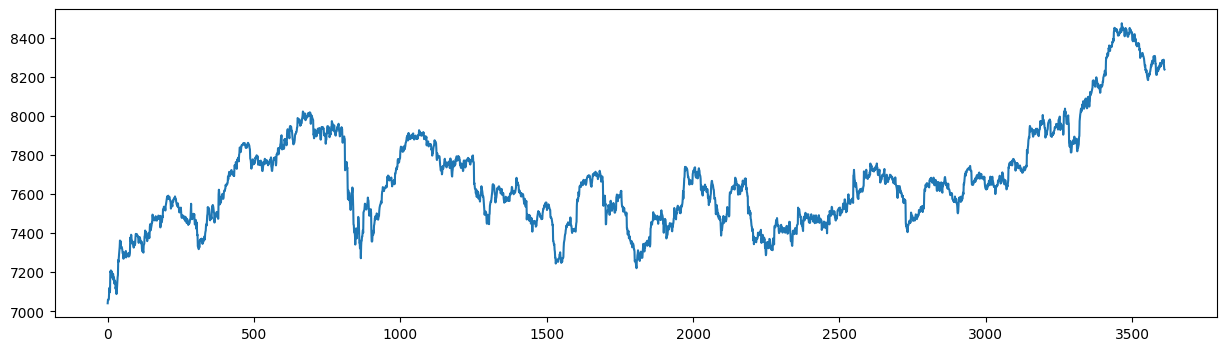

In [10]:
%matplotlib inline
plt.figure(figsize=(15, 4))
plt.plot(range(len(train)), train["Close"])
plt.show()

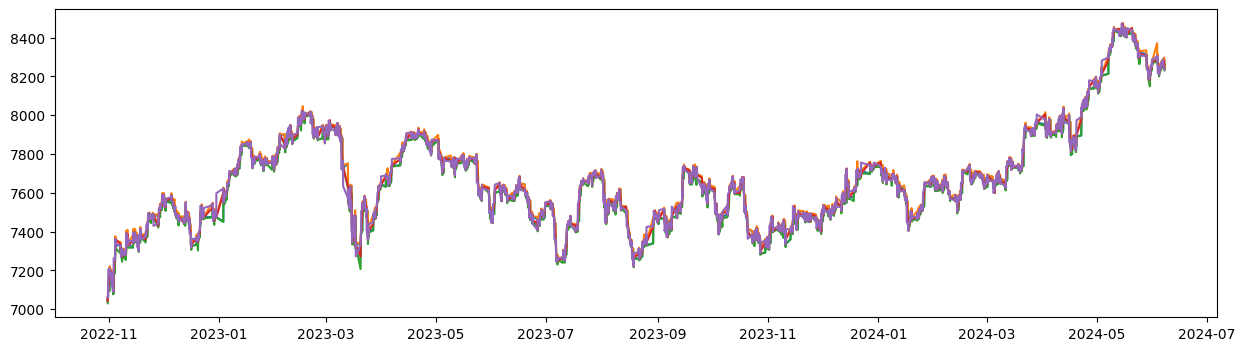

In [11]:
plt.figure(figsize=(15, 4))
plt.plot(train)
plt.show()

In [12]:
def data_process(data, window_size, predict_size):
    scaler1 = StandardScaler()
    scaler2 = StandardScaler()
    d_y = scaler1.fit_transform(data.iloc[:,-1:])
    data = scaler2.fit_transform(data.iloc[:,:4])

    data_in = []
    data_out = []
    # range(window_size,len(data)-predict_size+1) range(data.shape[0] - window_size - predict_size + 1)
    for i in range(window_size,len(data)-predict_size+1):
        data_in.append(data[i-window_size:i,0:data.shape[0]])
        data_out.append(d_y[i + predict_size - 1:i + predict_size,0])

    data_in = np.array(data_in)
    data_out = np.array(data_out)

    data_process = {'datain': data_in, 'dataout': data_out}

    return data_process, scaler1 , scaler2

In [13]:
from numpy.random import default_rng
from qiskit_algorithms.utils import algorithm_globals
qubits = 4
seed = 42
np.random.seed(seed)
torch.manual_seed(42)
rng = default_rng(seed)
algorithm_globals.random_seed = seed
features_size = 4
#window_size = features_size * 3
window_size = 10
predict_size = 1

In [14]:
train_processed, train_target_scalar, train_scaler = data_process(train, window_size, predict_size)
X_train, y_train = train_processed['datain'], train_processed['dataout']

test_processed, test_target_scalar, test_scaler = data_process(test, window_size, predict_size)
X_test, y_test = test_processed['datain'], test_processed['dataout']

In [15]:
X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))

y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

In [16]:
print(X_train.shape)
X_train[0][0]

torch.Size([3602, 10, 4])


tensor([-2.4197, -2.4377, -2.4382, -2.4465])

In [17]:
class QLSTM(nn.Module):
    def __init__(self,
                input_size,
                hidden_size,
                n_qubits=4,
                n_qlayers=1,
                batch_first=True,
                return_sequences=False,
                return_state=False,
                backend="default.qubit"):
        super(QLSTM, self).__init__()
        self.n_inputs = input_size
        self.hidden_size = hidden_size
        self.concat_size = self.n_inputs + self.hidden_size
        self.n_qubits = n_qubits
        self.n_qlayers = n_qlayers
        self.backend = backend  # "default.qubit", "qiskit.basicaer", "qiskit.ibm"

        self.batch_first = batch_first
        self.return_sequences = return_sequences
        self.return_state = return_state

        #self.dev = qml.device("default.qubit", wires=self.n_qubits)
        #self.dev = qml.device('qiskit.basicaer', wires=self.n_qubits)
        #self.dev = qml.device('qiskit.ibm', wires=self.n_qubits)
        # use 'qiskit.ibmq' instead to run on hardware

        self.wires_forget = [f"wire_forget_{i}" for i in range(self.n_qubits)]
        self.wires_input = [f"wire_input_{i}" for i in range(self.n_qubits)]
        self.wires_update = [f"wire_update_{i}" for i in range(self.n_qubits)]
        self.wires_output = [f"wire_output_{i}" for i in range(self.n_qubits)]

        self.dev_forget = qml.device(self.backend, wires=self.wires_forget)
        self.dev_input = qml.device(self.backend, wires=self.wires_input)
        self.dev_update = qml.device(self.backend, wires=self.wires_update)
        self.dev_output = qml.device(self.backend, wires=self.wires_output)

        def _circuit_forget(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_forget)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_forget)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_forget]
        self.qlayer_forget = qml.QNode(_circuit_forget, self.dev_forget, interface="torch")

        def _circuit_input(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_input)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_input)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_input]
        self.qlayer_input = qml.QNode(_circuit_input, self.dev_input, interface="torch")

        def _circuit_update(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_update)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_update)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_update]
        self.qlayer_update = qml.QNode(_circuit_update, self.dev_update, interface="torch")

        def _circuit_output(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_output)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_output)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_output]
        self.qlayer_output = qml.QNode(_circuit_output, self.dev_output, interface="torch")

        weight_shapes = {"weights": (n_qlayers, n_qubits)}
        print(f"weight_shapes = (n_qlayers, n_qubits) = ({n_qlayers}, {n_qubits})")

        self.clayer_in = torch.nn.Linear(self.concat_size, n_qubits)
        self.VQC = {
            'forget': qml.qnn.TorchLayer(self.qlayer_forget, weight_shapes),
            'input': qml.qnn.TorchLayer(self.qlayer_input, weight_shapes),
            'update': qml.qnn.TorchLayer(self.qlayer_update, weight_shapes),
            'output': qml.qnn.TorchLayer(self.qlayer_output, weight_shapes)
        }
        self.clayer_out = torch.nn.Linear(self.n_qubits, self.hidden_size)
        #self.clayer_out = [torch.nn.Linear(n_qubits, self.hidden_size) for _ in range(4)]

    def forward(self, x, init_states=None):
        '''
        x.shape is (batch_size, seq_length, feature_size)
        recurrent_activation -> sigmoid
        activation -> tanh
        '''
        #print('av',len(x.size()))
        if self.batch_first is True and len(x.size()) == 3:
            batch_size, seq_length, features_size = x.size()
        else:
            seq_length, batch_size = x.size()

        hidden_seq = []
        if init_states is None:
            h_t = torch.zeros(batch_size, self.hidden_size)  # hidden state (output)
            c_t = torch.zeros(batch_size, self.hidden_size)  # cell state
        else:
            # for now we ignore the fact that in PyTorch you can stack multiple RNNs
            # so we take only the first elements of the init_states tuple init_states[0][0], init_states[1][0]
            h_t, c_t = init_states
            #h_t = h_t[0]
            #c_t = c_t[0]

        for t in range(seq_length):
            # get features from the t-th element in seq, for all entries in the batch
            #x_t = x[:, t, :]
            
            #x_t = x[:, t]
            # Concatenate input and hidden 
            x_t = x
            #print('x',x.size())
            #print('t',t)
            #print('xt',x_t.size())
            #print('ht',h_t.size())
            v_t = torch.cat((x_t, h_t), dim=1)

            # match qubit dimension
            y_t = self.clayer_in(v_t)

            f_t = torch.sigmoid(self.clayer_out(self.VQC['forget'](y_t)))  # forget block
            i_t = torch.sigmoid(self.clayer_out(self.VQC['input'](y_t)))  # input block
            g_t = torch.tanh(self.clayer_out(self.VQC['update'](y_t)))  # update block
            o_t = torch.sigmoid(self.clayer_out(self.VQC['output'](y_t))) # output block

            c_t = (f_t * c_t) + (i_t * g_t)
            h_t = o_t * torch.tanh(c_t)

            hidden_seq.append(h_t.unsqueeze(0))
        hidden_seq = torch.cat(hidden_seq, dim=0)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()
        return hidden_seq, (h_t, c_t)

class QRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units, n_qubits=0, n_qlayers=1):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = QLSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            n_qubits = n_qubits,
            n_qlayers= n_qlayers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()

        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out

In [18]:
device = "cpu"

In [19]:
class AttnEncoder(nn.Module):
    def __init__(self,input_size: int, hidden_size: int, batch_first: bool = True, n_qubits:int=4, n_qlayers:int=1,seq_len:int=10):
        super(AttnEncoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.batch_first = batch_first
        self.seq_len = seq_len
        self.lstm = QLSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            batch_first=True,
            n_qubits = n_qubits,
            n_qlayers= n_qlayers
        )
        self.attn = nn.Linear(
            in_features=2 * self.hidden_size + self.seq_len,
            out_features=1
        )
        self.softmax = nn.Softmax(dim=1)


    def forward(self, input_data: torch.Tensor):
        
        if self.batch_first is True and len(input_data.size())==3:
            batch_size, seq_length, features_size = input_data.size()
        else:
            batch_size, features_size = input_data.size()

        h_t = Variable(torch.zeros(batch_size, self.hidden_size))  # hidden state (output)
        c_t = Variable(torch.zeros(batch_size, self.hidden_size))  # cell state

        attentions, input_encoded = (Variable(torch.zeros(input_data.size(0), self.seq_len, self.input_size)),
                                     Variable(torch.zeros(input_data.size(0), self.seq_len, self.hidden_size)))


        for t in range(self.seq_len):
            x = torch.cat((h_t.repeat(self.input_size, 1, 1).permute(1, 0, 2),
                           c_t.repeat(self.input_size, 1, 1).permute(1, 0, 2),
                           input_data.permute(0, 2, 1).to(device)), dim=2).to(
                device)  # bs * input_size * (2 * hidden_dim + seq_len)

            e_t = self.attn(x.view(-1, self.hidden_size * 2 + self.seq_len))  # (bs * input_size) * 1
            a_t = self.softmax(e_t.view(-1, self.input_size)).to(device)  # (bs, input_size)

            weighted_input = torch.mul(a_t, input_data[:, t, :].to(device))  # (bs * input_size)
            #self.lstm.flatten_parameters()
            #print('x,et,at',x.size(), e_t.size(), a_t.size())
            #print('atinputdaata',input_data[:,t,:].size())
            #print('winput',weighted_input.size())
            
            _, (h_t, c_t) = self.lstm(weighted_input, (h_t, c_t))

            input_encoded[:, t, :] = h_t
            attentions[:, t, :] = a_t

        return attentions, input_encoded

In [20]:
class AttnDecoder(nn.Module):
    def __init__(self, hidden_size: int, batch_first: bool = True, n_qubits:int=4, n_qlayers:int=1,seq_len:int=10):
        super(AttnDecoder, self).__init__()
        self.batch_first = batch_first
        self.seq_len = seq_len
        self.lstm = QLSTM(
            input_size=1,
            hidden_size=hidden_size,
            batch_first=True,
            n_qubits = n_qubits,
            n_qlayers= n_qlayers
        )
        self.encoder_hidden_size = hidden_size
        self.decoder_hidden_size = hidden_size
        self.out_feats = 1

        self.attn = nn.Sequential(
            nn.Linear(2 * self.decoder_hidden_size + self.encoder_hidden_size, self.encoder_hidden_size),
            nn.Tanh(),
            nn.Linear(self.encoder_hidden_size, 1)
        )
        
        self.fc = nn.Linear(self.encoder_hidden_size + self.out_feats, self.out_feats)
        self.fc_out = nn.Linear(self.decoder_hidden_size + self.encoder_hidden_size, self.out_feats)
        self.fc.weight.data.normal_()

    def forward(self, input_encoded: torch.Tensor, y_history: torch.Tensor):
        if self.batch_first is True and len(input_encoded.size())==3:
            batch_size, seq_length, features_size = input_encoded.size()
        else:
            batch_size, features_size = input_encoded.size()
        
        h_t = Variable(torch.zeros(batch_size, self.decoder_hidden_size))  # hidden state (output)
        c_t = Variable(torch.zeros(batch_size, self.decoder_hidden_size))  # cell state
        
        context = Variable(torch.zeros(input_encoded.size(0), self.encoder_hidden_size))

        for t in range(self.seq_len):
            x = torch.cat((h_t.repeat(self.seq_len, 1, 1).permute(1, 0, 2),
                           c_t.repeat(self.seq_len, 1, 1).permute(1, 0, 2),
                           input_encoded.to(device)), dim=2)

            x = tf.softmax(
                self.attn(
                    x.view(-1, 2 * self.decoder_hidden_size + self.encoder_hidden_size)
                ).view(-1, self.seq_len),
                dim=1)

            context = torch.bmm(x.unsqueeze(1), input_encoded.to(device))[:, 0, :]  # (batch_size, encoder_hidden_size)
           # print('con_yhis',context.size(),y_history.size())
            y_tilde = self.fc(torch.cat((context.to(device), y_history.to(device)),
                                        dim=1))  # (batch_size, out_size)

            #self.lstm.flatten_parameters()
           # print('ytilde', y_tilde.size())
            _, (h_t, c_t) = self.lstm(y_tilde, (h_t, c_t))
        #print('ht_con', h_t.size(),context.size())
        return self.fc_out(torch.cat((h_t, context.to(device)), dim=1))  # predicting value at t=self.seq_length+1


In [21]:
class AutoEncForecast(nn.Module):
    def __init__(self,input_size: int, hidden_size: int, batch_first: bool = True, n_qubits:int=4, n_qlayers:int=1,seq_len:int=10):
        super(AutoEncForecast, self).__init__()
        self.encoder = AttnEncoder(input_size, hidden_size, batch_first, n_qubits, n_qlayers,seq_len).to(device)
        self.decoder = AttnDecoder(hidden_size, batch_first, n_qubits, n_qlayers,seq_len).to(device)

    def forward(self, encoder_input: torch.Tensor, y_hist: torch.Tensor, return_attention: bool = False):
       
        attentions, encoder_output = self.encoder(encoder_input)
        outputs = self.decoder(encoder_output, y_hist.float())
        outputs = torch.transpose(outputs, 0, 1)
        if return_attention:
            return outputs, attentions
        return outputs

In [22]:
batch_size = 4
learning_rate = 0.004
num_epochs = 5
trainDataloader = DataLoader(TensorDataset(X_train, y_train), batch_size = batch_size, shuffle = False)
testDataloader = DataLoader(TensorDataset(X_test,y_test), batch_size = batch_size, shuffle = False)
device = "cpu"
modelQ = AutoEncForecast(input_size=4, hidden_size= 6, n_qubits=4)
criterion = nn.MSELoss()
optimizerQ = torch.optim.Adam(modelQ.parameters(), lr = learning_rate, betas = (0.0, 0.9))

weight_shapes = (n_qlayers, n_qubits) = (1, 4)
weight_shapes = (n_qlayers, n_qubits) = (1, 4)


In [23]:
histQ = np.zeros(num_epochs)
histQacc = np.zeros(num_epochs)
count = 0


for epoch in range(num_epochs):
    loss_Q = []
    rmse_q = []
    correct = 0
    batches = 0
    for (x, y) in trainDataloader:
        modelQ.zero_grad()
        x = x.to(device)
        y = y.to(device)
        
        output = modelQ(x,y)
        
        label = torch.transpose(y, 0, 1)    
        #print(output)
        #print(torch.transpose(y, 0, 1))
        
        lossQ = criterion(output, label)
        lossQ.backward()
        optimizerQ.step()
        
        #correct += (output == label).float().sum()
        #batches +=1
        
        loss_Q.append(lossQ.item())
    histQ[epoch] = np.sum(loss_Q)
    #print(correct)
    #histQacc[epoch] = correct/batches
    print(f'[{epoch+1}/{num_epochs}]  LossQ:{np.sum(loss_Q)} ')

[1/5]  LossQ:51.7371856844311 
[2/5]  LossQ:2.332843695663769 
[3/5]  LossQ:1.3523836650103362 
[4/5]  LossQ:0.8966421360633205 
[5/5]  LossQ:0.6432375266117845 


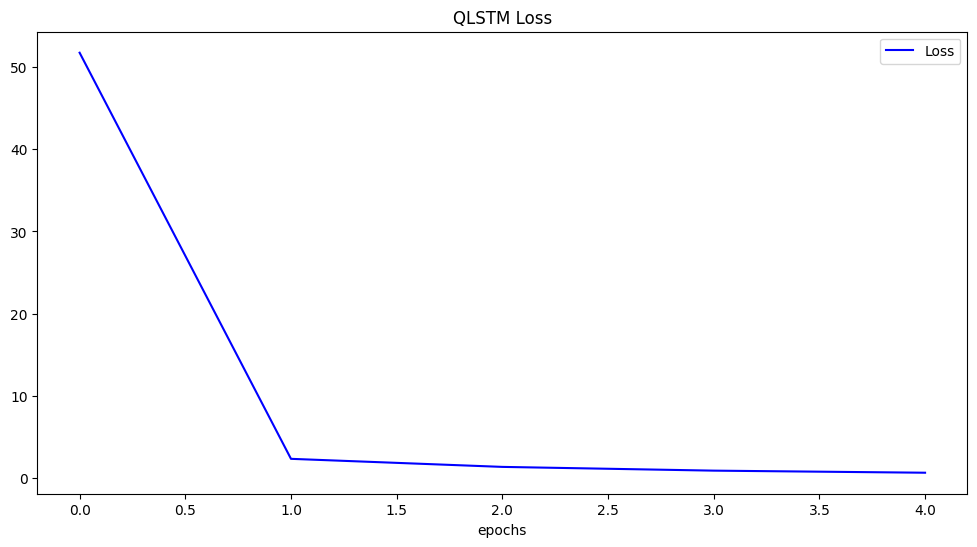

In [24]:
np.savetxt('./SavedModels/Stock/FTSE/loss/qlstm_attn.txt',histQ)
plt.figure(figsize = (12, 6))
plt.plot(histQ, color = 'blue', label = 'Loss')
plt.title('QLSTM Loss')
plt.xlabel('epochs')
plt.legend(loc = 'upper right')

In [25]:
print(len(X_test))
print(len(X_train))
print(len(y_train))
#print(X_train[0].unsqueeze(0))
#print(y_train[0].unsqueeze(0))

893
3602
3602


In [26]:
def predict(X,y, model):
    """Just like `test_loop` function but keep track of the outputs instead of the loss
    function.
    """
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for i in range(len(X)):
            y_star = model(X[i].unsqueeze(0),y[i].unsqueeze(0))
            '''if list(y_star.size()) == [1,1]:
                y_star = y_star.tolist()
                y_star[0]+= [y_star[0][0]]
                y_star[0]+= [y_star[0][0]]
                y_star[0]+= [y_star[0][0]]
                y_star = torch.tensor(y_star)'''
            output = torch.cat((output, y_star), 0)


    return output

In [27]:
pred_y_test = predict(X_test,y_test, modelQ)
print(len(pred_y_test))
print(pred_y_test)

893
tensor([[-2.8797e-01],
        [-3.9934e-01],
        [-4.4916e-01],
        [-2.6769e-01],
        [-1.0915e-01],
        [-4.5364e-01],
        [-1.0090e+00],
        [-9.9379e-01],
        [-1.1820e+00],
        [-1.3668e+00],
        [-1.3747e+00],
        [-1.2337e+00],
        [-1.3664e+00],
        [-5.4320e-01],
        [-4.2765e-01],
        [-6.1293e-01],
        [-6.1205e-01],
        [-4.7111e-01],
        [-2.1505e-01],
        [-2.1139e-01],
        [-3.7130e-01],
        [-2.0275e-01],
        [-5.5552e-01],
        [-8.2952e-01],
        [-8.7472e-01],
        [-9.6402e-01],
        [-7.8921e-01],
        [-7.7070e-01],
        [-1.1383e+00],
        [-1.2219e+00],
        [-1.1469e+00],
        [-1.1819e+00],
        [-1.2763e+00],
        [-1.5032e+00],
        [-1.5856e+00],
        [-1.3270e+00],
        [-1.1518e+00],
        [-1.2171e+00],
        [-1.2990e+00],
        [-1.2133e+00],
        [-1.1618e+00],
        [-1.3330e+00],
        [-1.4087e+00],
       

In [28]:
pred_y_train = predict(X_train,y_train, modelQ)
print(len(pred_y_train))
print(pred_y_train)

3602
tensor([[-1.7209],
        [-1.7455],
        [-1.7304],
        ...,
        [ 2.2302],
        [ 2.2233],
        [ 2.2204]])


In [29]:
pred_y_train = pred_y_train.reshape(-1, 1)
pred_y_test = pred_y_test.reshape(-1, 1)


In [30]:
print(len(pred_y_train))
print(len(y_train))

3602
3602


In [31]:
pred_y_test

tensor([[-2.8797e-01],
        [-3.9934e-01],
        [-4.4916e-01],
        [-2.6769e-01],
        [-1.0915e-01],
        [-4.5364e-01],
        [-1.0090e+00],
        [-9.9379e-01],
        [-1.1820e+00],
        [-1.3668e+00],
        [-1.3747e+00],
        [-1.2337e+00],
        [-1.3664e+00],
        [-5.4320e-01],
        [-4.2765e-01],
        [-6.1293e-01],
        [-6.1205e-01],
        [-4.7111e-01],
        [-2.1505e-01],
        [-2.1139e-01],
        [-3.7130e-01],
        [-2.0275e-01],
        [-5.5552e-01],
        [-8.2952e-01],
        [-8.7472e-01],
        [-9.6402e-01],
        [-7.8921e-01],
        [-7.7070e-01],
        [-1.1383e+00],
        [-1.2219e+00],
        [-1.1469e+00],
        [-1.1819e+00],
        [-1.2763e+00],
        [-1.5032e+00],
        [-1.5856e+00],
        [-1.3270e+00],
        [-1.1518e+00],
        [-1.2171e+00],
        [-1.2990e+00],
        [-1.2133e+00],
        [-1.1618e+00],
        [-1.3330e+00],
        [-1.4087e+00],
        [-1

In [32]:
y_train_true = train_target_scalar.inverse_transform(y_train)
y_train_pred = train_target_scalar.inverse_transform(pred_y_train.cpu().detach().numpy())
y_test_true = test_target_scalar.inverse_transform(y_test)
y_test_pred = test_target_scalar.inverse_transform(pred_y_test.cpu().detach().numpy())

In [33]:
np.savetxt('./SavedModels/Stock/FTSE/train/qlstm_attn.txt',y_train_pred)
np.savetxt('./SavedModels/Stock/FTSE/test/qlstm_attn.txt',y_test_pred)

Training dataset RMSE:23.085180995929584


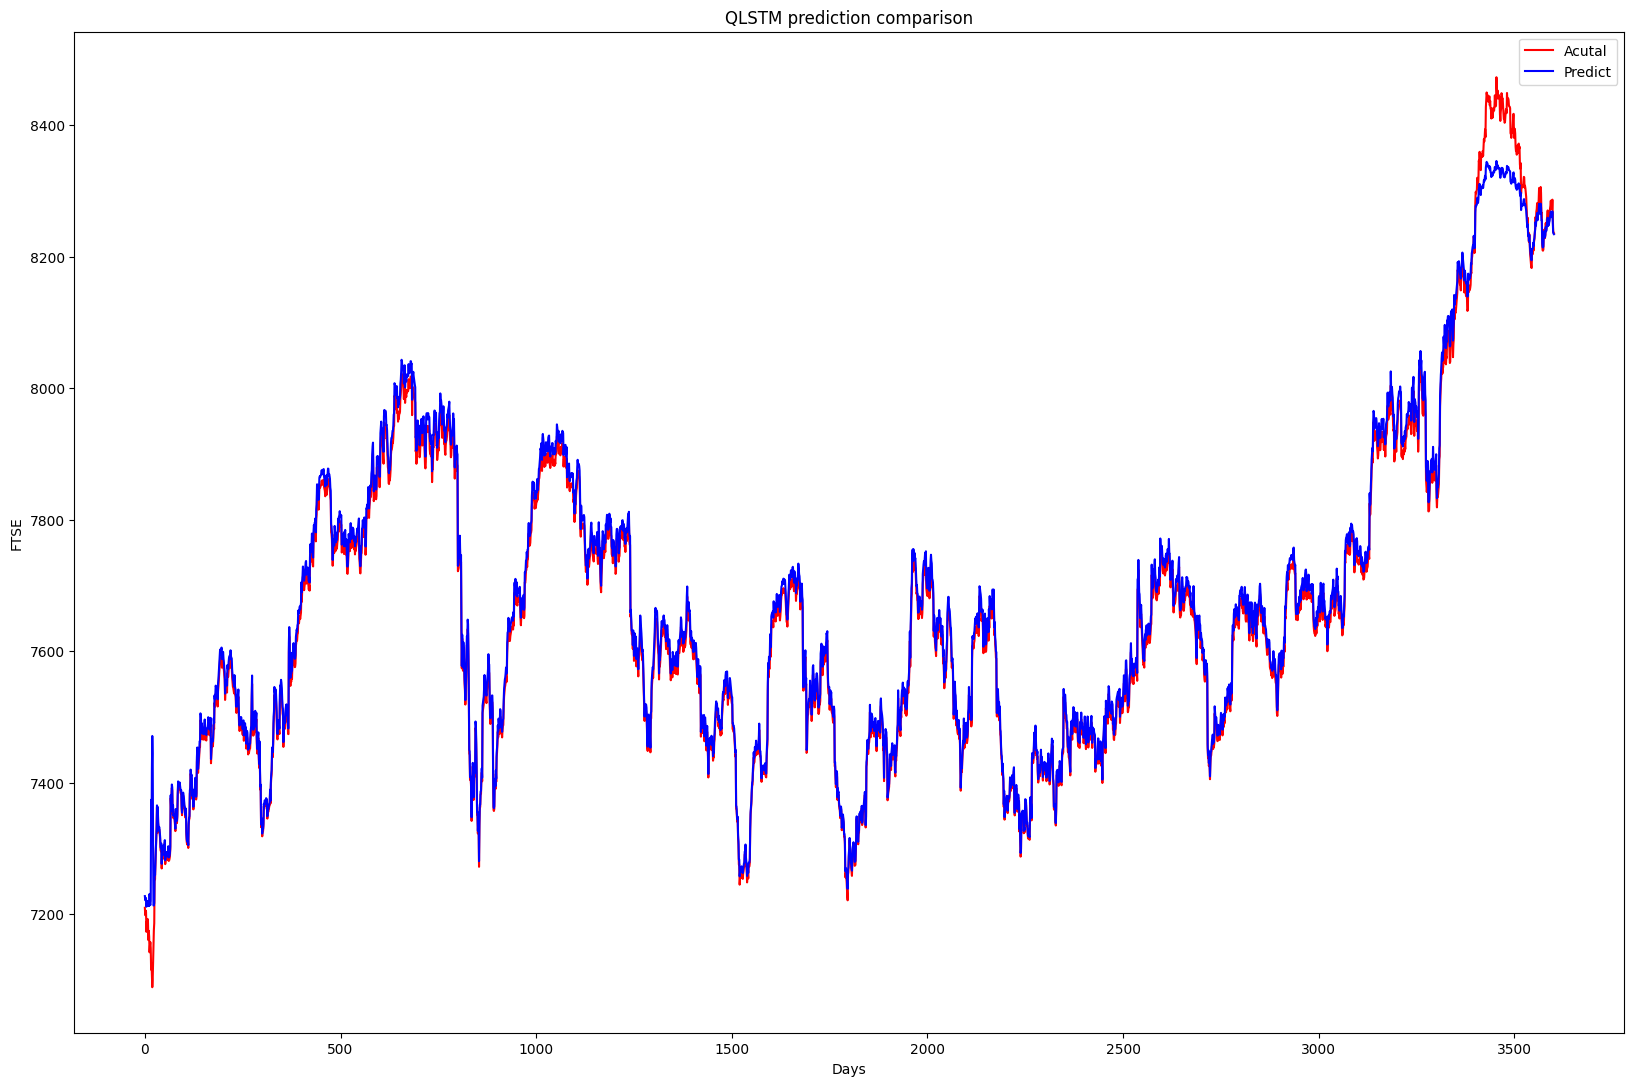

In [34]:
plt.figure(figsize=(20, 13))
plt.plot(y_train_true, color = 'red', label = 'Acutal')
plt.plot(y_train_pred, color = 'blue', label = 'Predict')
plt.title('QLSTM prediction comparison')
plt.ylabel('FTSE')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_train_true, y_train_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

Training dataset RMSE:30.288380424935674


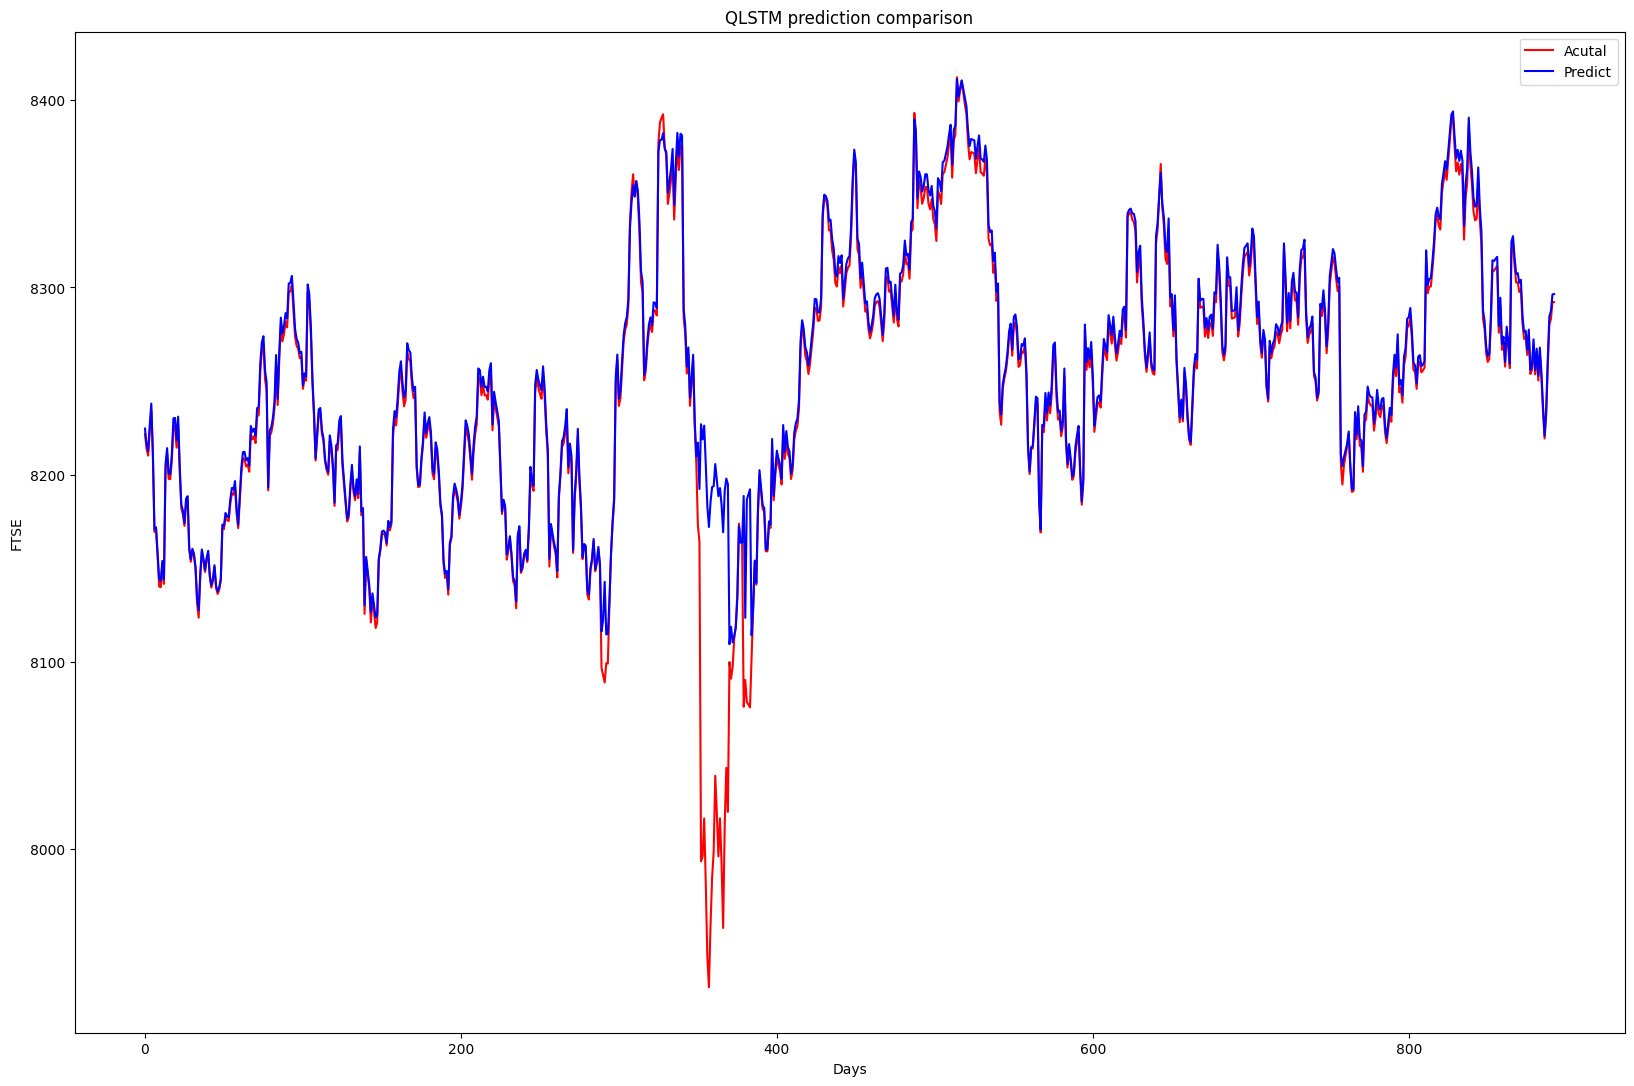

In [35]:
plt.figure(figsize=(20, 13))
plt.plot(y_test_true, color = 'red', label = 'Acutal')
plt.plot(y_test_pred, color = 'blue', label = 'Predict')
plt.title('QLSTM prediction comparison')
plt.ylabel('FTSE')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_test_true, y_test_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

In [36]:
torch.save(modelQ.state_dict(),'./SavedModels/Stock/FTSE/model/QLSTM_attn_sd')